In [1]:
import numpy as np
import os
import os.path
import src.visualization.display as dsp
import netCDF4 as nc
import matplotlib.pyplot as plt
import torch
from pytorch_lightning import Trainer,seed_everything,LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import src.cnn as cnn
import scipy.ndimage.morphology as scm
import importlib
import matplotlib.ticker as mtick
importlib.reload(dsp)

/Users/coulaud/opt/anaconda3/envs/DL-normalization/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'src.visualization.display' from '/Users/coulaud/Documents/DL-normalization/src/visualization/display.py'>

In [2]:
os.getcwd()

'/Users/coulaud/Documents/DL-normalization/notebooks'

In [3]:
norm_std = 110439.79485414618
norm_mean = 525208.1680871231

In [4]:
model = cnn.CNN.load_from_checkpoint("../../epoch=998-val_loss=0.00002.ckpt")
X=np.load("../data/processed/isotropic_noise100_samples_standardize/train/X/sphere_polecontinent16.npz")['arr_0']
X=torch.from_numpy(X[np.newaxis,:]).float()
print(X.shape)
X = X[:,:,10:-10,:]

#plt.imshow(X[0,0,:,:])

#X=X
Y=np.load("../data/processed/isotropic_noise100_samples_standardize/train/Y/sphere_polecontinent16_norm_coeffs.npz")['arr_0']
mask = np.where(Y[10:-10,:]==0,True,False)
Y = Y[10:-10,:]*norm_std + norm_mean
Y_pred = model.forward(X).detach().numpy()[0,0,:,44:-44]*norm_std + norm_mean
#mask = np.where(Y==0,True,False)
eps = (Y_pred**2 - Y**2)/Y**2
eps = np.ma.masked_array(eps, mask)

torch.Size([1, 3, 180, 448])


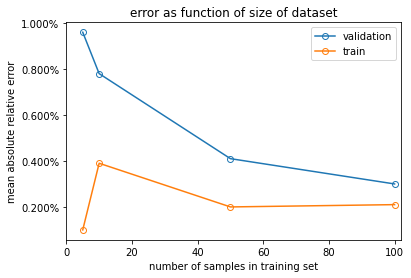

In [5]:
fig,ax = plt.subplots()
ns = [5,10,50,100]
val_error = [0.0096,0.0078,0.0041,0.003]
train_error = [0.001,0.0039,0.002,0.0021]
ax.plot(ns,val_error,"o-",markerfacecolor='none',label="validation",)
ax.plot(ns,train_error,"o-",markerfacecolor='none',label="train")
#ax.semilogy(ranges[:-1],means2,"o-",markerfacecolor='none',label="ronneberger")
#ax.semilogy(ranges[:-1],means3,"o-",markerfacecolor='none',label="pix2pix5 + 2x2conv normalised")
ax.set_xlim(0,102)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=3, symbol='%', is_latex=False))
ax.set_ylabel("mean absolute relative error")
ax.set_xlabel("number of samples in training set")
ax.set_title("error as function of size of dataset")
ax.legend()

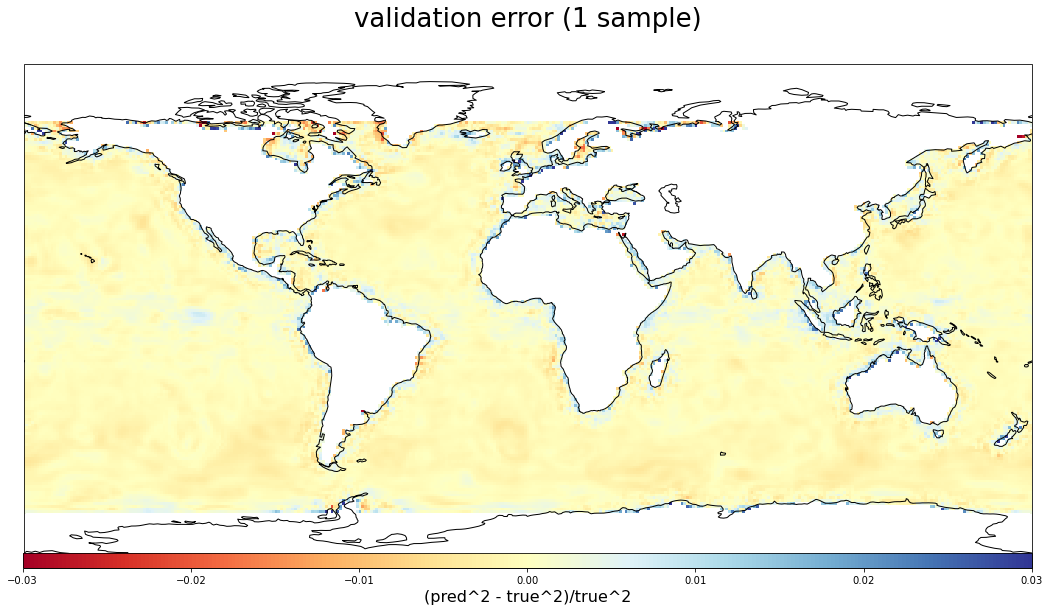

mean:  0.001864346613412052
max:  0.07738864173723324


In [6]:
importlib.reload(dsp)
lon = np.arange(-180, 180)
lat = np.arange(-80, 80)
lon2d, lat2d = np.meshgrid(lon, lat)
dsp.plot_error_globe(eps, lon2d, lat2d,vmin=-0.03,vmax=0.03,cmap="RdYlBu",
                     cmap_title="(pred^2 - true^2)/true^2",title="validation error (1 sample)")
print("mean: ",np.mean(np.abs(eps)))
print("max: ",np.max(np.abs(eps)))

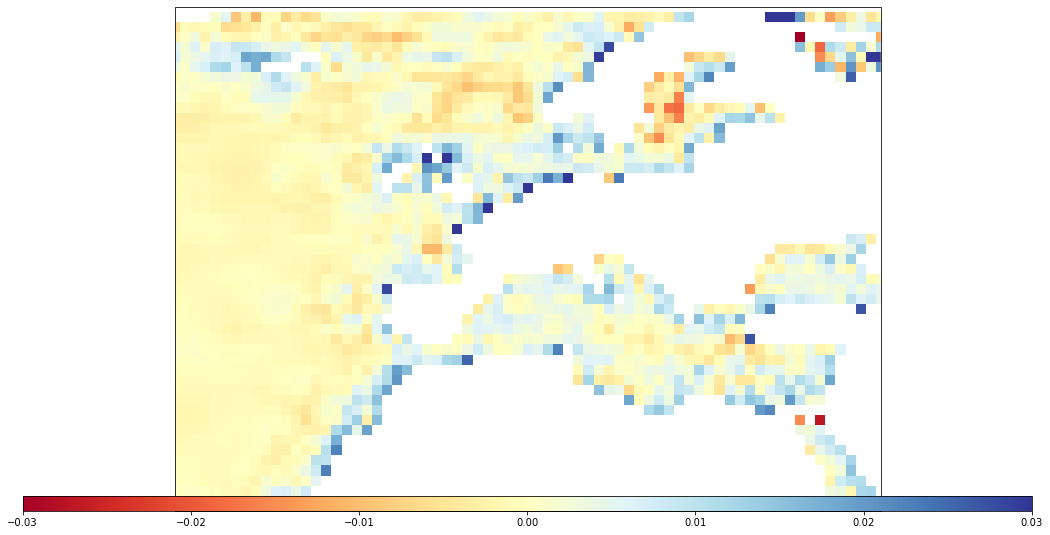

In [7]:
dsp.plot_error_region(np.ma.masked_array(eps, mask), 
                       lon2d, lat2d,region="europe",cmap="RdYlBu",vmin=-0.03,vmax=0.03)

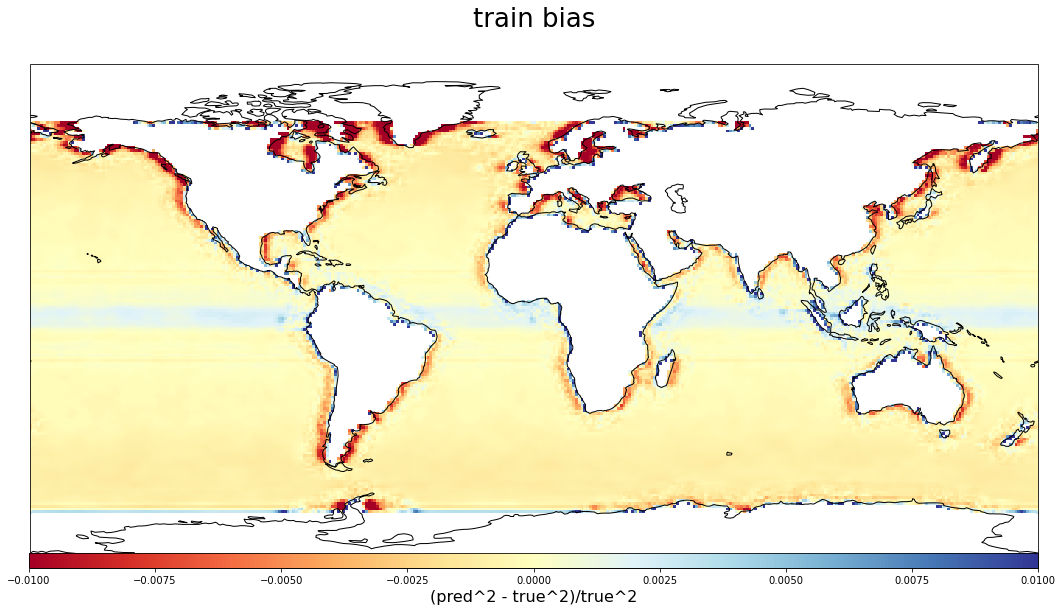

mean:  0.0013592267801574179
max:  0.03891896222974515


In [12]:
model = cnn.CNN.load_from_checkpoint("../../epoch=998-val_loss=0.00002.ckpt")
std = norm_std
mean = norm_mean
dir_path="../data/processed/isotropic_noise100_samples_standardize/train/X/"
eps = np.empty((len(os.listdir(dir_path)),160,360))
for i,file_list in enumerate(os.listdir(dir_path)):
    X=np.load(dir_path+file_list)['arr_0']
    X=torch.from_numpy(X[np.newaxis,:]).float()
    X = X[:,:,10:-10,:]
    Y=np.load("../data/processed/isotropic_noise100_samples_standardize/train/Y/" + file_list.split(".")[0]+"_norm_coeffs.npz")['arr_0']
    if i==0:
        mask = np.where(Y[10:-10,:]==0,True,False) 
    Y = Y[10:-10,:]*std + mean
    Y_pred = model.forward(X).detach().numpy()[0,0,:,44:-44]*std + mean
    aux = (Y_pred**2 - Y**2)/Y**2
    eps[i,:,:] = np.ma.masked_array(aux, mask)
    
importlib.reload(dsp)
lon = np.arange(-180, 180)
lat = np.arange(-80, 80)
lon2d, lat2d = np.meshgrid(lon, lat)
dsp.plot_error_globe(np.ma.masked_array(np.mean(eps,axis=0), mask), lon2d, lat2d,vmin=-0.01,vmax=0.01,cmap="RdYlBu",
                     cmap_title="(pred^2 - true^2)/true^2",title="train bias")
print("mean: ",np.mean(np.abs(np.ma.masked_array(np.mean(eps,axis=0), mask))))
print("max: ",np.max(np.abs(np.ma.masked_array(np.mean(eps,axis=0), mask))))

In [ ]:
import matplotlib.ticker as mtick


n=60
ranges = np.linspace(0.9,np.max(dst),n)
means = np.zeros(n-1)
means1 = np.zeros(n-1)
means2 = np.zeros(n-1)
means3 = np.zeros(n-1)
print(type(dst))
for i in range(len(ranges[:-1])):
    means[i] = np.mean(np.abs(eps[np.nonzero((dst<ranges[i+1]) & (dst>ranges[i]))]))
    means1[i] = np.mean(np.abs(eps1[np.nonzero((dst<ranges[i+1]) & (dst>ranges[i]))]))
    means2[i] = np.mean(np.abs(eps2[np.nonzero((dst<ranges[i+1]) & (dst>ranges[i]))]))
    means3[i] = np.mean(np.abs(eps8[np.nonzero((dst<ranges[i+1]) & (dst>ranges[i]))]))
fig,ax = plt.subplots()
ax.semilogy(ranges[:-1],means,"o-",markerfacecolor='none',label="pix2pix",)
ax.semilogy(ranges[:-1],means1,"o-",markerfacecolor='none',label="pix2pix + 2x2conv")
ax.semilogy(ranges[:-1],means2,"o-",markerfacecolor='none',label="ronneberger")
ax.semilogy(ranges[:-1],means3,"o-",markerfacecolor='none',label="pix2pix5 + 2x2conv normalised")
ax.set_xlim(0.,50)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=3, symbol='%', is_latex=False))
ax.set_ylabel("absolute relative error")
ax.set_xlabel("euclidean distance (in cells)")
ax.set_title("error averaged over distance to coast intervals")

In [10]:
model

CNN(
  (cnv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (cnv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (cnv3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (cnv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (cnv5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad